In [1]:
from modeling.gen2.execution import Component, edges_from_components
from modeling.compute import Var
from graph.operators import invert_edges, sort_scc
from graph.graphutils import flat_graph_formulation
from graph.graphutils import edges_E, all_edges
from graph.graphutils import all_variables
from graph.graphview import draw
from graph.matrixview import render_incidence
from graph.operators import eqv_to_edges_tree
from collections import OrderedDict
import numpy as np

# Edge case where two Functionals have same output

In [2]:
a = Var('a')
b = Var('b')
c = Var('c', 10)
d = Var('d', 20)

In [3]:
eqlist = [(b, c+1), (a, b-2), (a, 2*d+3)]

In [4]:
components = [Component.fromsympy(
    right, left, component=idx) for idx, (left, right) in enumerate(eqlist)]
edges = edges_from_components(components)

In [5]:
from modeling.gen2.transformations import flatten_component
rescomps = list(map(flatten_component, components))
rescomps

[(('c', 'b'), 0, (None,), 'b-(c + 1)'),
 (('b', 'a'), 1, (None,), 'a-(b - 2)'),
 (('d', 'a'), 2, (None,), 'a-(2*d + 3)')]

In [6]:
components[0].function(11)

[DeviceArray(12., dtype=float32)]

In [7]:
rescomps[2].graddict({'a':1,'d':1})

{'d': DeviceArray(-2., dtype=float32), 'a': DeviceArray(1., dtype=float32)}

In [8]:
residuals = invert_edges(edges[0], edges[1]) #{0: 'b', 1:'a'}

In [9]:
edges_left_right = all_edges(edges[0], edges[1])
edges_varonleft = edges_E(residuals[0])
outset = {key:var[0] for key,var in edges[1].items()}
eqnidxs= outset.keys()
varidxs = all_variables(edges[0], edges[1])

In [10]:
from presolver.tearing import min_arc_set_assign

In [11]:
fixed_inputs = set(varidxs)-set(outset.values())
fixed_inputs = ['c']
xsol, model  = min_arc_set_assign(edges_varonleft, varidxs, eqnidxs, not_output=fixed_inputs)
outset_minassign = dict((right, left) for left, right in edges_varonleft if xsol[left, right] > 0.5)

Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-13


In [12]:
edges_minassign=invert_edges(edges[0], edges[1], outset_minassign) 

In [13]:
edges_minassign

({0: ('c',), 1: ('b',), 2: ('a',)}, {0: ('b',), 1: ('a',), 2: ('d',)}, {})

In [14]:
tree = (OrderedDict([(0,1),(1,1),(2,1)]),{},{})

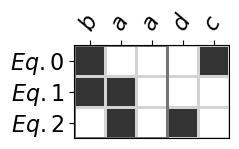

In [15]:
render_incidence(edges, tree, 
                 rawvarname=True, 
                 figsize=(2,2),
                 diagonalgray=False);

In [16]:
from graph.operators import reformulate

In [17]:
nedges, ntree = reformulate(edges, tree, outset, outset_minassign)

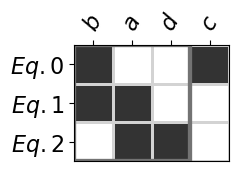

In [18]:
render_incidence(nedges, ntree, 
                 rawvarname=True, 
                 figsize=(2,2),
                 diagonalgray=False, patchwidth=3);

In [19]:
from graph.graphutils import Node, COMP
import networkx as nx
G = flat_graph_formulation(*edges)
matching = nx.bipartite.maximum_matching(G)
m_out = {key: matching[Node(key, COMP)].name for key in eqnidxs}
merge_order = sort_scc(G)

In [20]:
invert_edges(edges[0], edges[1], m_out) 

({0: ('b',), 1: ('a',), 2: ('a',)}, {0: ('c',), 1: ('b',), 2: ('d',)}, {})

In [22]:
from trash.inputresolver import eqvars
from trash.inputresolver import default_in, default_out
from trash.inputresolver import mdf_order
from graph.graphview import bipartite_repr

In [23]:
eqlist

[(b, c + 1), (a, b - 2), (a, 2*d + 3)]

In [24]:
eqs = {idx: eq for idx, eq in enumerate(eqlist)}
eqv = eqvars(eqs)

In [25]:
dout = default_out(eqs)

In [26]:
ins = default_in(eqs)
ins

{c, d}

In [27]:
B, edge = bipartite_repr(eqv)

In [28]:
M = nx.bipartite.maximum_matching(B)

In [29]:
M

{d: 2, c: 0, a: 1, 0: c, 1: a, 2: d}

In [30]:
order = mdf_order(eqv, M)

In [31]:
order

[0, 1, 2]

In [32]:
solve_order = ([0,1],2)

In [33]:
def compute_order(seq_order, solve_order, parent=0, counter=0):
    counter+=1
    group = '{}.{}'.format(parent, counter)
    print(' '*len(group), 'create group: ', group)
    if solve_order:
        order = solve_order
        print(' '*len(group),'create system solver for ',group)
        if seq_order:
            compute_order(seq_order, (), group, counter)
    else:
        print(' '*len(group),'default sequential solver for ', group)
        order = seq_order
    for idx, eqnelt in enumerate(order):
        if isinstance(eqnelt, list):
            counter = compute_order(eqnelt, (), group, counter)
        elif isinstance(eqnelt, tuple):
            if isinstance(eqnelt[0], list):
                ordered = eqnelt[0]
                unordered = eqnelt[1:]
            else:
                ordered = []
                unordered = eqnelt
            counter = compute_order(ordered, unordered, group, counter)
        else:
            print(' '*(len(group)+2),'add to ', group, ' eq: ', eqnelt)
    return counter

In [34]:
compute_order([],solve_order);

    create group:  0.1
    create system solver for  0.1
      create group:  0.1.2
      default sequential solver for  0.1.2
        add to  0.1.2  eq:  0
        add to  0.1.2  eq:  1
      add to  0.1  eq:  2


In [35]:
# prob = om.Problem()
# model = prob.model
# counter = coupled_run(eqs, [], solve_order, model, model, 0)
# buildidpvars(ins, model)
# prob.setup()
# prob.run_model()

In [35]:
(b-(c+1))

b - c - 1

In [36]:
ev = Component.fromsympy(b-(c+1))

In [37]:
ev.evaldict({'b':1,'c':2})

-2

In [38]:
A = np.array([[0, 1, -1],[1, -1, 0],[1, 0, 0]])
B = np.array([1, -2, 5])
np.linalg.solve(A, B)

array([5., 7., 6.])

In [39]:
[rescomp.evaldict({'a':5,'b':7,'c':6,'d':1}) for rescomp in rescomps]

[[DeviceArray([0.], dtype=float32)],
 [DeviceArray([0.], dtype=float32)],
 [DeviceArray([0.], dtype=float32)]]

In [40]:
vrs = all_variables(edges[0], edges[1])

In [41]:
from engine.foundations.functionalsets import ResidualSet
from engine.foundations.functionalsets import FunctionalComp
from engine.foundations.functionalsets import DefaultResidualSolver
components = [Component.fromsympy(right, left, 
                                  component=idx, arg_mapping=True) 
                                  for idx, (left, right) in enumerate(eqlist)]
functionals = [FunctionalComp(comp) for comp in components]
S = ResidualSet(sum([functional.projectable.components for functional in functionals], []))
F = S.project([d])

In [42]:
F.solve({d: 1})

{c: 6.000000146219812, b: 7.000000159285115, a: 5.000000123712407}

In [43]:
import openmdao.api as om
from engine.gen2mdao.postprocess import print_output_mdao

In [44]:
class ImpWithInitial(om.ImplicitComponent):
    def initialize(self):
        self.options.declare('residuals')
        self.options.declare('solvefor')
        self.options.declare('inputs')
        
    def setup(self):
        solvefor = self.options['solvefor']
        inputs = self.options['inputs']
        for input in inputs:
            self.add_input(input)
        for output in solvefor:
            self.add_output(output, val=0.1)
        self.declare_partials(of='*', wrt='*')

    def apply_nonlinear(self, inputs, outputs, residuals):
        solvefor_vars = self.options['solvefor']
        input_vars = self.options['inputs']
        rescomps = self.options['residuals']
        d = {elt: inputs[elt] for elt in input_vars}
        d.update({elt: outputs[elt] for elt in solvefor_vars})
        for solve_var,rescomp in zip(solvefor_vars, rescomps):
            residuals[solve_var] = rescomp.evaldict(d)
        
    def linearize(self, inputs, outputs, partials):
        solvefor_vars = self.options['solvefor']
        input_vars = self.options['inputs']
        rescomps = self.options['residuals']
        d = {elt: inputs[elt] for elt in input_vars}
        d.update({elt: outputs[elt] for elt in solvefor_vars})
        for solve_var,rescomp in zip(solvefor_vars, rescomps):
            J = rescomp.graddict(d)
            partials[solve_var, solve_var] = 0
            for varname in solvefor_vars:
                partials[solve_var, varname] = J.get(varname, 0)
        
prob = om.Problem()
model = prob.model

model.add_subsystem('comp', ImpWithInitial(
    residuals=rescomps, solvefor={'a','b','c'}, inputs={'d'}), promotes=['*'])
model.nonlinear_solver = om.NewtonSolver(solve_subsystems=False)
model.linear_solver = om.ScipyKrylov()

prob.setup()
prob.run_model()

NL: Newton Converged in 1 iterations


In [45]:
print_output_mdao(prob)

c:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\core\system.py:136: OMDeprecationWarning:The metadata key 'value' will be deprecated in 4.0. Please use 'val'.


{'b': 6.999999999999999, 'a': 4.999999999999999, 'c': 6.0}